# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 

## Import Packages

In [1]:
#importing some useful packages
from glob import glob
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.ndimage.measurements import label
from collections import deque

from helper_functions import get_hog_features, bin_spatial, extract_features, slide_window, convert_color, add_heat, apply_threshold, draw_labeled_bboxes 

%matplotlib inline

## Load Classifier Parameters

In [2]:
classifier_params = pickle.load(open("classifier_params.pkl", "rb"))
svc = classifier_params['svc']
X_scaler = classifier_params['X_scaler']
orient = classifier_params['orient']
pix_per_cell = classifier_params['pix_per_cell']
cell_per_block = classifier_params['cell_per_block']
spatial_size = classifier_params['spatial_size']

## Find Cars In An Image

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size):
    
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    # Debug variables
    show_portion = False
    show_all_boxes = False
        
    img_tosearch = img[ystart:ystop,xstart:xstop]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    #ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if(True == show_portion):
        portion_feature, portion_hog_image = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
        
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
                        
            if (test_prediction == 1) | (True == show_all_boxes):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                pt1 = (xbox_left+xstart, ytop_draw+ystart)
                pt2 = (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)
                
                if(True == show_portion):
                    portion_pt1 = (pt1[0] - xstart, pt1[1] - ystart)
                    portion_pt2 = (pt2[0] - xstart, pt2[1] - ystart)
                    cv2.rectangle(img_tosearch,portion_pt1,portion_pt2,(255,255,255),6)
                
                boxes.append((pt1,pt2))
       
    if(True == show_portion):
        fig = plt.figure(figsize=(15, 8))
        #plt.imshow(img_tosearch)       
        #plt.title('Image Portion') 
        #plt.title('Image Portion Sliding Window')
        plt.imshow(ch1) 
        plt.title('Image Portion YCrCb Y Channel')
        #plt.imshow(portion_hog_image)        
        #plt.title('Image Portion YCrCb HOG')
                
    return boxes

## Detections

In [4]:
def get_detections(img):    
    #ystart = 400
    #ystop = 680
    # Smaller scale numbers imply smaller box
    ystart_ystop_scales = [(400, 500, 600, 1100, 1), (400, 570, 700, 1280, 1.2), (400, 620, 800, 1280, 1.5), (400, 690, 900, 1280, 1.6)]
    #ystart_ystop_scales = [(400, 570, 700, 1280, 1.2)]
    
    img = img.astype(np.float32)/255    
    
    # Empty list to hold boxes for the current image
    boxes = []

    # Search for cars in different portions of the image with different scales
    for ystart, ystop, xstart, xstop, scale in ystart_ystop_scales:
        boxes.extend(find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size))
    
    return boxes

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


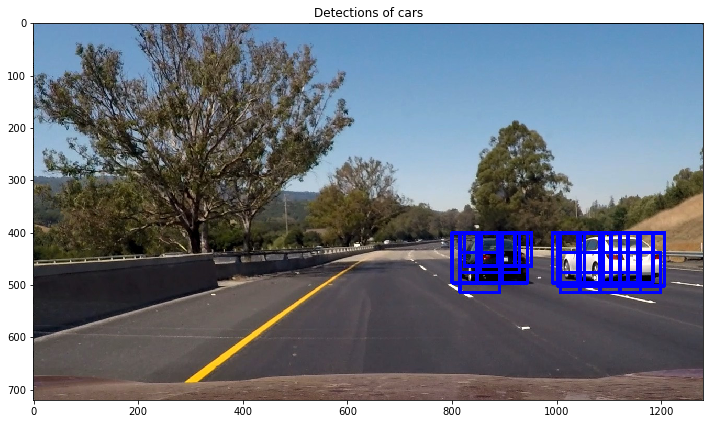

In [5]:
test_image = mpimg.imread('test_images/test6.jpg')

draw_img = np.copy(test_image)
boxes = get_detections(test_image)
        
if 0 != len(boxes):
    for box in boxes:
        pt1 = box[0]
        pt2 = box[1]
        #print(pt1, pt2, type(pt1), type(pt2))
        cv2.rectangle(draw_img,pt1,pt2,(0,0,255),6) 

plt.figure(figsize = (12, 8))
plt.imshow(draw_img)
plt.title('Detections of cars')
#plt.title('Sliding fixed window on lower half of the image')
#plt.title('Sliding window on first portion')
#plt.title('Sliding window on second portion')
#plt.title('Sliding window on third portion')
#plt.title('Sliding window on fourth portion')
#plt.title('Combined sliding window on all portions')

## Get single bounding box for a car using heat map

In [6]:
def get_bounding_box(img, boxes):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

In [7]:
test_image = mpimg.imread('test_images/test6.jpg')

draw_img = np.copy(test_image)

boxes = get_detections(test_image)

heatmap = get_bounding_box(test_image, boxes)

labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


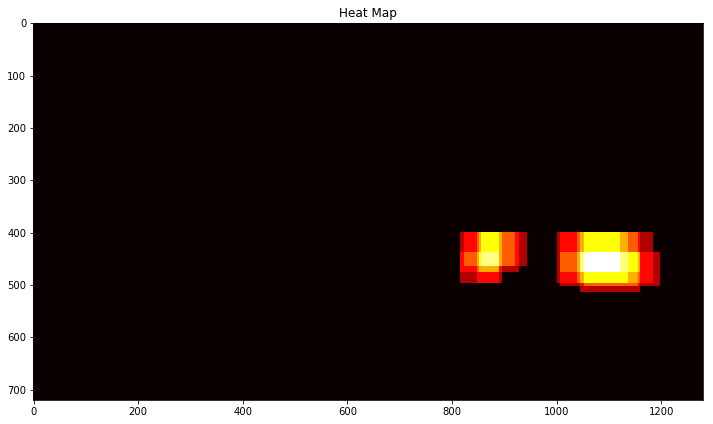

In [8]:
plt.figure(figsize = (12, 8))
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

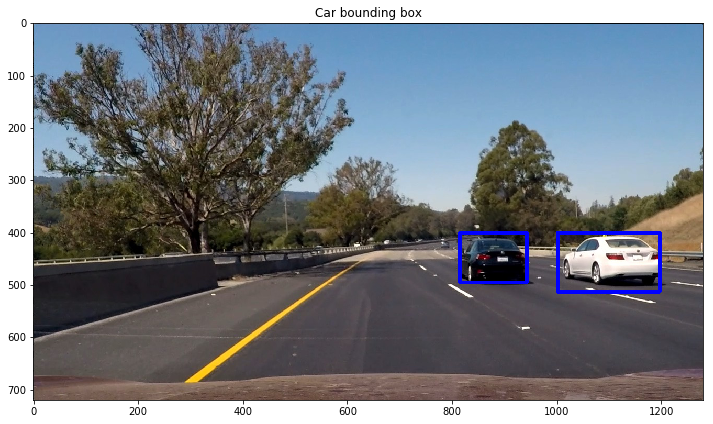

In [9]:
plt.figure(figsize = (12, 8))
plt.imshow(draw_img)
plt.title('Car bounding box')

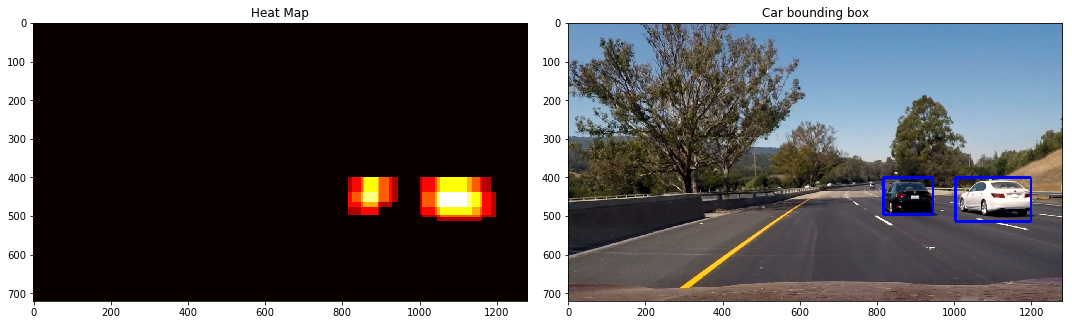

In [10]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(122)
plt.imshow(draw_img)
plt.title('Car bounding box')
fig.tight_layout()

## Vehicle Detection class

In [11]:
class Vehicle_Detection:
    def __init__(self):
        # Frame count
        self.debug = False;
        # Frame count
        self.frame_count = 0;
        # Frame count
        self.n_frames = 10;            
        # Heat map for Last n frames
        self.current_heatmap = None
        # Heat map for Last n frames
        self.heatmap_n_frames = [None for i in range(self.n_frames)]
        # Average Heat map over Last n frames
        self.avg_heatmap = None
        # Labels
        self.labels = None        
        if(True == self.debug):
            # Boxes for last n frames
            self.boxes_n_frames = [None for i in range(self.n_frames)]
            # Image with boxes for last n frames
            self.boxes_image_n_frames = [None for i in range(self.n_frames)]
        
    def avg_heatmaps(self):
        # Extract index from frame count
        index = (self.frame_count - 1) % self.n_frames
        # Store the current frame's heatmap into buffer
        self.heatmap_n_frames[index] = self.current_heatmap
        # Get the number of buffer count
        if(self.frame_count < self.n_frames):
            num_of_buffer = self.frame_count
        else:
            num_of_buffer = self.n_frames
            
        # Create an array to hold the sum of heatmaps of previous n frames
        sum_heatmap = np.zeros_like(self.current_heatmap)
        for index in range(num_of_buffer):
            sum_heatmap += self.heatmap_n_frames[index]
        
        # Get the average heatmap over n frames
        self.avg_heatmap = sum_heatmap/(num_of_buffer/2)        
        # Label the averaged heatmap
        self.labels = label(self.avg_heatmap)
        return self.labels
    
    def draw_boxes_on_image(self):   
        # Extract index from frame count
        index = (self.frame_count - 1) % self.n_frames     
        if 0 != len(self.boxes_n_frames[index]):
            for box in self.boxes_n_frames[index]:
                pt1 = box[0]
                pt2 = box[1]
                cv2.rectangle(self.boxes_image_n_frames[index],pt1,pt2,(0,0,255),6) 
        
        

## Vehicle Detection Pipeline

In [12]:
def pipeline(img):
    # Keep track of frame count
    vehicle_det.frame_count += 1
        
    # Get raw detections
    boxes = get_detections(img)        
         
    if(True == vehicle_det.debug):
        buffer_index = vehicle_det.frame_count-1
        vehicle_det.boxes_image_n_frames[buffer_index] = np.copy(img)
        vehicle_det.boxes_n_frames[buffer_index] = boxes    
        vehicle_det.draw_boxes_on_image()

    # Get heatmap for current frame
    vehicle_det.current_heatmap = get_bounding_box(img, boxes)
    
    # Average the heatmap over multiple frames to get labels
    vehicle_det.labels = vehicle_det.avg_heatmaps()    
    
    # Draw single bounding box for a car
    draw_img = draw_labeled_bboxes(np.copy(img), vehicle_det.labels)
    
    return draw_img
    

## Vehicle Detection Pipeline on single image

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


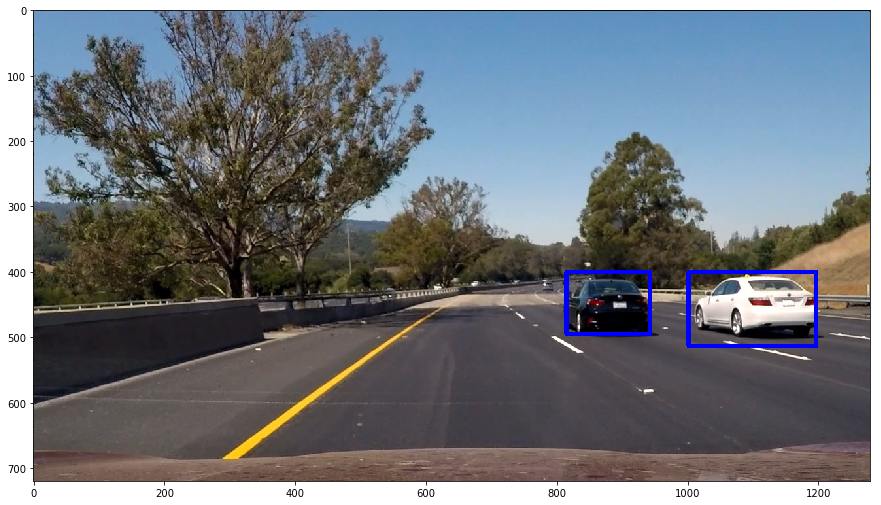

In [13]:
test_image = mpimg.imread('test_images/test6.jpg')
vehicle_det = Vehicle_Detection()
draw_test_image = pipeline(test_image)
fig = plt.figure(figsize=(15, 15))
plt.imshow(draw_test_image)

## Extract frames from Video

In [ ]:
vidcap = cv2.VideoCapture('test_video.mp4')
print(vidcap)
cap_success, video_frame = vidcap.read()
print('Read a new frame: ', cap_success)
video_frame_count = 0
cap_success = True
while (cap_success & (video_frame_count < 10)):
  cap_success, video_frame = vidcap.read()
  print('Read a new frame: ', cap_success)
  cv2.imwrite("./output_images/video_frame%d.jpg" % video_frame_count, video_frame)     # save frame as JPEG file
  video_frame_count += 1

## Vehicle Detection Pipeline on image series

In [ ]:
vehicle_det = Vehicle_Detection()

for video_frame_num in range(10):
    video_frame = 'output_images/video_frame%d.jpg' % video_frame_num
    frame = mpimg.imread(video_frame)
    video_frame_out = pipeline(frame)
    fig = plt.figure(video_frame_num, figsize=(8, 8))
    plt.subplot(121)
    plt.imshow(vehicle_det.boxes_image_n_frames[video_frame_num])
    plt.title('Detections Frame%d' % video_frame_num)
    plt.subplot(122)
    plt.imshow(vehicle_det.heatmap_n_frames[video_frame_num], cmap='hot')
    plt.title('Heat Map Frame%d' % video_frame_num)
    fig.tight_layout()


In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(vehicle_det.labels[0])
plt.title('Label on averaged Heat Map')
fig = plt.figure(figsize=(10, 10))
plt.imshow(video_frame_out)
plt.title('Car bounding box')

## Vehicle Detection Pipeline on video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
t=time.time()
vehicle_det = Vehicle_Detection()
#test_video_output = "./test_video_output.mp4"
#clip1 = VideoFileClip("./test_video.mp4")
test_video_output = "./project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4").subclip(28,32)
white_clip1 = clip1.fl_image(pipeline)
%time white_clip1.write_videofile(test_video_output, audio=False)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to process the video...')

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [16:32<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 17min 47s, sys: 1.68 s, total: 17min 49s
Wall time: 16min 33s
994.01 Seconds to process the video...


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))